## Analysis, Prediction, Recommendation For Churn Rate of a telecom
Raymond Kwok 23 June 2019 (rmwkwok at gmail.com)

# Purpose
1. Given a < 1MB telecom client dataset of 7043 rows and 21 columns, I shall analyze the dataset and produce a prediction model of churn probability, and find out how the probability depends on features and how to reduce it. One interesting point is that some columns' names are encoded and I will define them based on my understanding.

2. This work has 3 notebooks. 
    - This one focuses on exploratory data analysis and feature engineering, that an engineered dataset is produced at the end
    - The dataset will be used in the second notebook for modeling with several approaches, among which I will select the best one based on a few metrics and I will show the feature's importance for the selected model
    - In the last notebook, I will suggest for actions that, based on the model, could effectively reduce the churn rate

## TOC
<a href=#a >A. How to improve churn rate</a><br>
<a href=#a1>>>A1 model behavior-1</a><br>
<a href=#a2>>>A2 model behavior-2</a><br><br>
<a href=#b >B. Summary</a><br><br>


## A. How to improve churn rate <a name='a' /></a>

Suggestions could be made based on EDA and studying the behavior of the model.

1. EDA:
    - Retention curve tells us there are 2 exponential processes with half lives being ~1 and ~9 months
    - This hints us to improve these groups' client retention, so in following work, I will divide clients into three groups by
        - lifetime = 1 month
        - lifetime between 2 to 9 months inclusive
        - lifetime > 9 months

2. model behavior - 1:
    - in each lifetime group, I will further categorize them by predicted churn probability
        - prob between [0.00-0.25) : safe
        - prob between [0.25,0.50) : low
        - prob between [0.50,0.75) : high
        - prob between [0.75,1.00] : danger
    - I will compare among these groups, how their averaged feature differ from each other, which will qualitatively tells us what feature needs attention and in what direction should it be changed towards.
    
3. model behavior - 2:
    - To quantiatively tells how much changing a particular feature could reduce churn rate, I will plot how churn rate changes as feature value of all clients changes.
    - As reference to compare, I will draw two horizontal lines for each plot. The 'mode' line indicates the churn level if the feature value of all clients change to the mode value. The 'current' line tells us the current churn rate.

In [1]:
# package
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


%load_ext autoreload
%autoreload 2

In [2]:
# read dataset
dataset = pd.read_csv('./checkpoint01_dataset.csv')

# read model result and feature importance
imp       = pickle.load(open('./checkpoint02_model_feature_importance_df.pkl','rb'))
result    = pickle.load(open('./checkpoint02_model_result_dict.pkl','rb'))
scaler    = pickle.load(open('./checkpoint02_model_scaler.pkl','rb'))
bestmodel = pickle.load(open('./checkpoint02_model_best_model_str.pkl','rb'))
bestmodel_importance = pickle.load(open('./checkpoint02_model_best_model_feature_importance_series.pkl','rb'))

# split to x and y
dataset_x = dataset.drop('is_churn', axis=1)
dataset_y = dataset['is_churn']

## A1 model behavior-1 <a name='a1' /></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


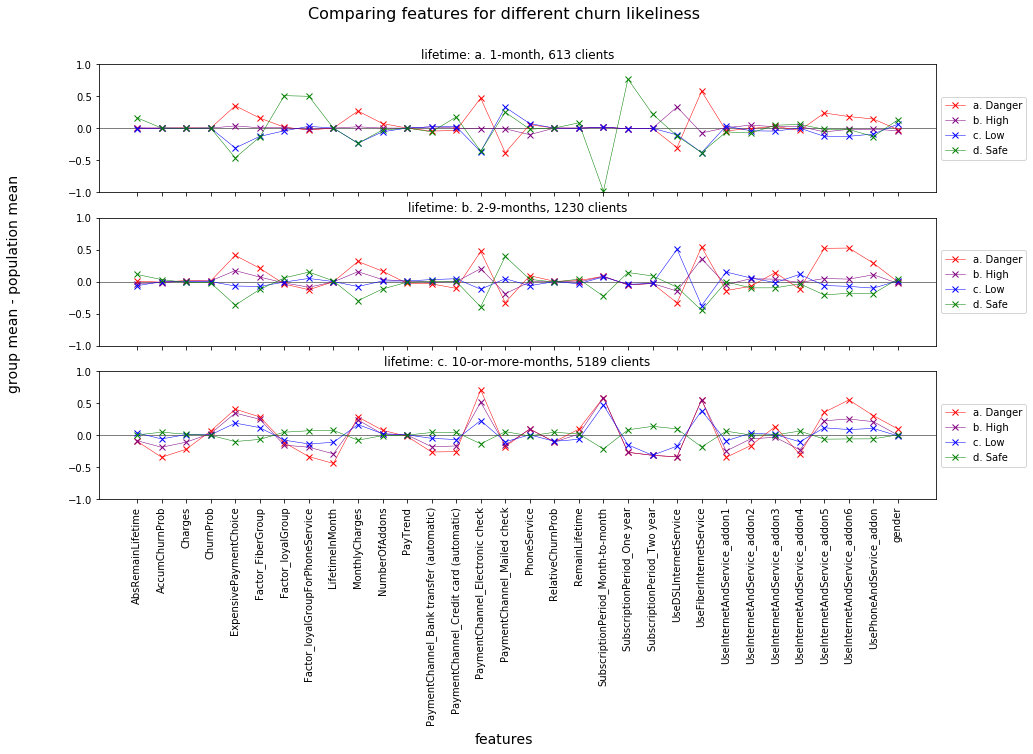

In [3]:
# prepare a dataset with prediction result

# get classifier and predicted probability
bestcls     = result[bestmodel]['gs'].best_estimator_
_dataset_x  = scaler.transform(dataset_x)
probability = bestcls.predict_proba(_dataset_x)

# save probability in a dataset copy
dataset_pred = dataset.copy()
dataset_pred['PredChurnProba']  = probability[:,1]  # column 1 for churn probability. 

# assign groups
dataset_pred['group_lifetime']  = dataset_pred['LifetimeInMonth']\
                                    .apply(lambda x: 'a. 1-month'    if x==1 else
                                                     'b. 2-9-months' if x<=9 else
                                                     'c. 10-or-more-months')
dataset_pred['group_churnprob'] = dataset_pred['PredChurnProba']\
                                    .apply(lambda x: 'd. Safe' if x<0.25 else
                                                     'c. Low'  if x<0.50 else
                                                     'b. High' if x<0.75 else
                                                     'a. Danger')

# standardize all features to the range between 0 and 1.
feature_cols = sorted(set(dataset_pred.columns) - 
                      set(['is_churn', 'PredChurnProba',
                           'group_lifetime','group_churnprob']))
dataset_pred[feature_cols] = MinMaxScaler()\
                                .fit_transform(dataset_pred[feature_cols])

# plot feature averages 
fig, axes = plt.subplots(3,1,figsize=(15,8), sharex=True)
fig.suptitle('Comparing features for different churn likeliness', fontsize=16)
fig.text(0.5, -0.3, 'features', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'group mean - population mean', va='center', rotation='vertical', fontsize=14)
axes = axes.flatten()
colors = ['red', 'purple', 'blue', 'green']

for ax, (g_lifetime, df0) in zip(axes, dataset_pred.groupby('group_lifetime')):
    mean_baseline = df0[feature_cols].mean(axis=0)
    ax.axhline(0, lw=0.5, c='black')
    
    for c, (g_churnprob, df1) in zip(colors, df0.groupby('group_churnprob')):
        df1_mean = df1[feature_cols].mean(axis=0) - mean_baseline
        ax.plot(feature_cols, df1_mean, c=c, marker='x', label=g_churnprob, lw=0.5)

    ax.set_title('lifetime: %s, %d clients'%(g_lifetime, len(df0)))
    ax.tick_params(axis='x', rotation=90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(-1,1)

plt.show()

Observations:
1. Dispersed features indicates room for improvement. For example, moving up the portion of users with 'Factor_loyalGroupForPhoneService' = 1 will decrease the churn rate.
2. This graph helps us focus on features that matters.

## A2 model behavior-2 <a name='a2' /></a>
This process can take a few minutes.

top 32 features explain 100% of overall importance


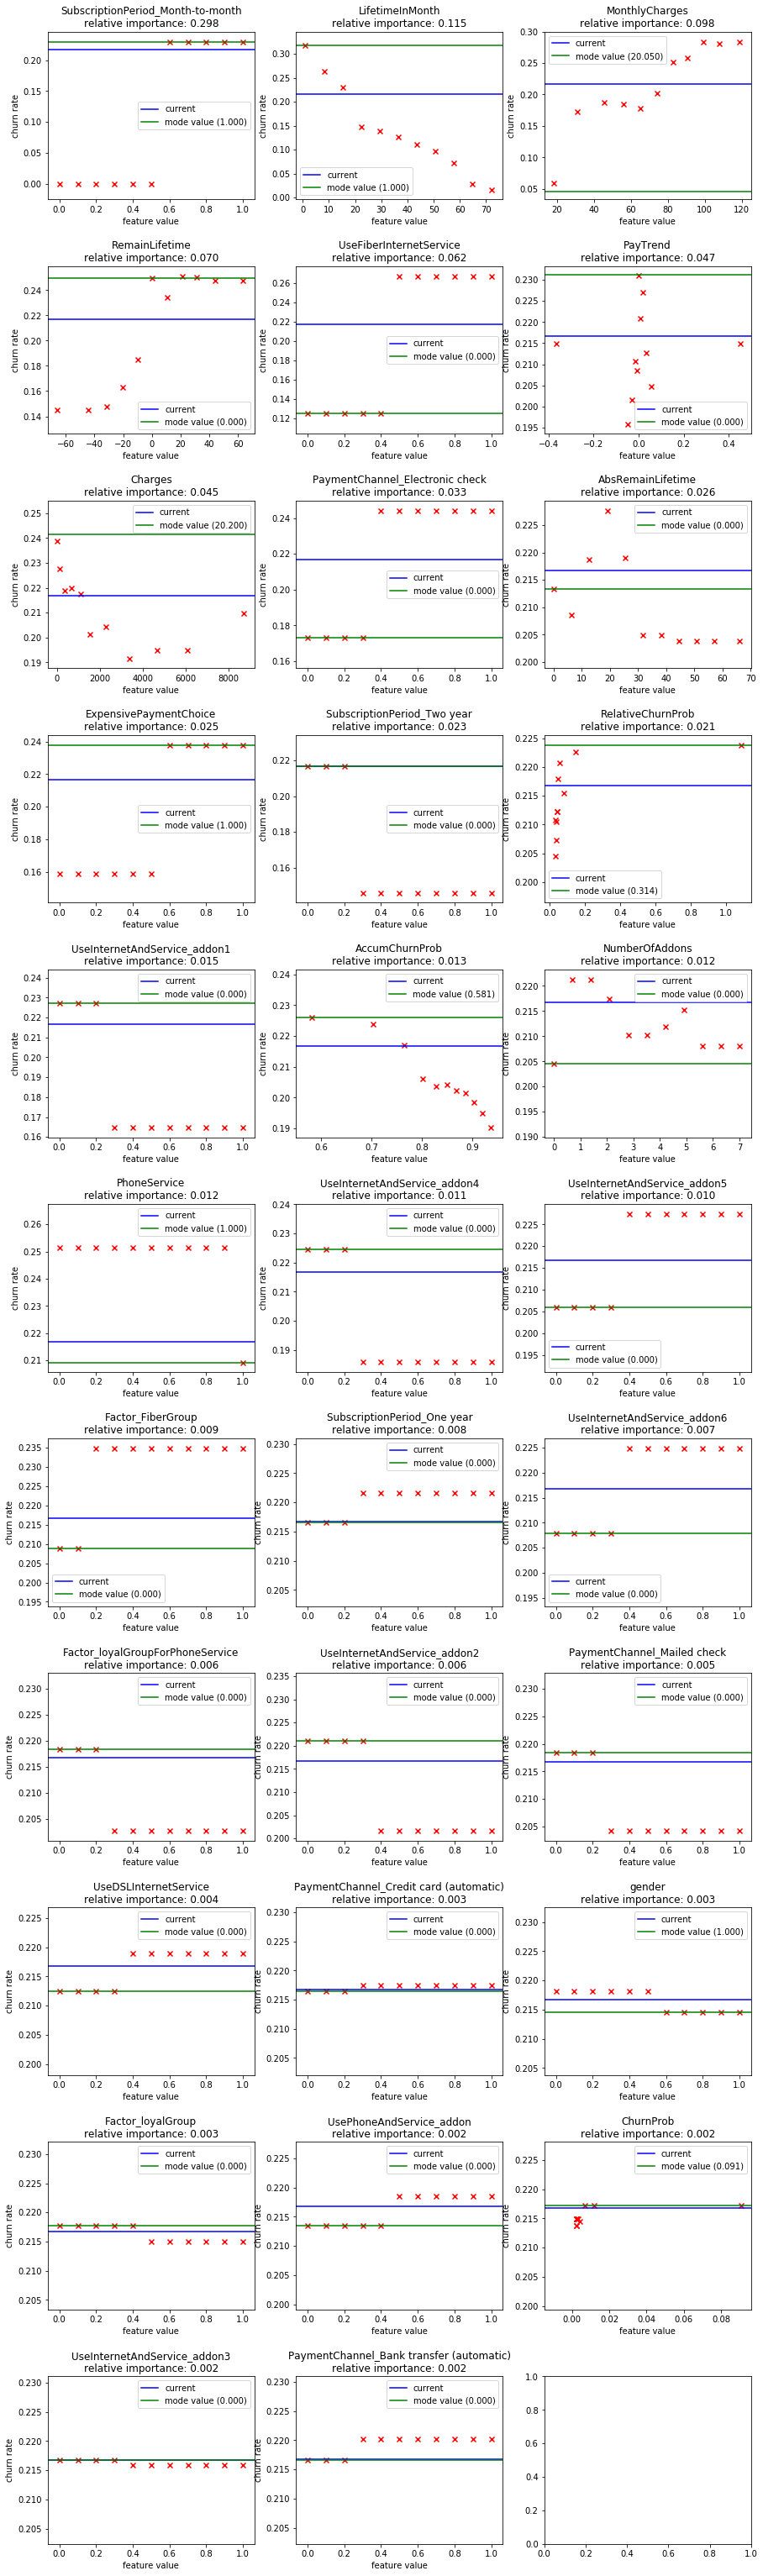

In [4]:
# Helper function
def churnrate(data):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data      = scaler.transform(data)
        predlabel = bestcls.predict(data)
        return predlabel.mean()
    
# indicate how many features to plot
n = len(bestmodel_importance)
top_features = bestmodel_importance.sort_values(ascending=False).iloc[0:n]
print('top %d features explain %.f%% of overall importance'%(n,100*top_features.sum()))

# prepare plots
ncol = 3
nrow = int(np.ceil(n/ncol))
fig, axes = plt.subplots(nrow,ncol,figsize=(5*ncol,5*nrow))
axes = axes.flatten()

# This calculates the current predicted churn rate
churn_rate_init = churnrate(dataset_x)
    
for ax, (feat, feat_imp) in zip(axes, top_features.iteritems()):
    
    # get the feature's mode, and its possible value
    # sample feature value to explore
    feat_mode   = dataset_x[feat].mode().values[0]
    feat_values = dataset_x[feat].unique()
    feat_values_explore = np.unique(np.quantile(feat_values, np.arange(0,1.1,0.1)))
    
    # change feat value to its mode, and get churn rate at mode value
    _dataset_x = dataset_x.copy()
    _dataset_x[feat] = feat_mode
    churn_rate_mode = churnrate(_dataset_x)
    
    # change feat value to explored values, and get their churn rates
    for feat_value in feat_values_explore:
        _dataset_x = dataset_x.copy()
        _dataset_x[feat] = feat_value
        churn_rate_value = churnrate(_dataset_x)
        ax.scatter(feat_value, churn_rate_value, marker='x', color='r')

    ax.set_title('%s\nrelative importance: %.3f'%(feat, feat_imp))
    ax.axhline(churn_rate_init, c='b', label='current')
    ax.axhline(churn_rate_mode, c='g', label='mode value (%.3f)'%feat_mode)
    ax.set_xlabel('feature value')
    ax.set_ylabel('churn rate')
    ax.legend()
    
plt.subplots_adjust(hspace=0.4)
plt.show()
    

Observations
1. The plots tell us in which direction to tune a feature value would give us a lower churn rate.
2. Normally more important feature (plot first) will have larger effect
3. Those with low effect to churn rate could be useful, if it is a service, then it is likely that promoting it to clients wouldn't harm the churn rate.
4. Those service that make churn rate worse should be reviewed to make clients satisify.

Cautions:
1. Some features are correlated (encoded label, monthly charges and services, etc.) , so it is naive to change one feature at a time, but that would give us some light on how each feature affects the churn rate.

Action plan:

Do more cheaper long-term plan, particularly avoid Internet service addon 5 and 6 (unless reason for boosting churn rate is found and fixed), however, the company could consider selling more Internet service addon 1,4 and PhoneService to maintain or increase the revenue, as their users stay longer.

## B. Summary <a name='b' /></a>
1. Action plan is suggested based on model's behavior. The action plan should be AB-tested, and the model shall be updated accordingly to learn new effect that happens to the user base.
2. User history activities with the company provides useful handles to make prediction, such as complaints, usage time length, change of service, and etc. It would be great if all relevant data could be considered.